### Imports

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm, naive_bayes
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import math

### Uploading dataset - 01

## Data Preprocessing

In [ ]:
## Product Reviews Dataset
df01=pd.read_csv(r"C:\Users\admin\Downloads\Text-Classification-master\Text-Classification-master\corpus.csv",encoding='latin-1')

### Upper case to lower case transformation

In [ ]:
df01['text']=[sentence.lower() for sentence in df01['text']]

In [ ]:
df01

,text,label
0,stuning even for the non-gamer: this sound tr...,__label__2
1,the best soundtrack ever to anything.: i'm re...,__label__2
2,amazing!: this soundtrack is my favorite musi...,__label__2
3,excellent soundtrack: i truly like this sound...,__label__2
4,"remember, pull your jaw off the floor after h...",__label__2
...,...,...
9995,a revelation of life in small town america in...,__label__2
9996,great biography of a very interesting journal...,__label__2
9997,interesting subject; poor presentation: you'd...,__label__1
9998,don't buy: the box looked used and it is obvi...,__label__1


### Reconstructing the sentence

In [ ]:
import re
def reconstruct(sentence):
    #Removes angular breaks
    sentence = re.sub(r"<br/>", " ", str(sentence))
    #Removes the words which are not started with alphabets
    sentence = re.sub(r"[^a-zA-Z]", " ", str(sentence))
    #Removing URL's
    sentence = re.sub(r"http\S+", " ", str(sentence))
    #Removing '@' symbols
    sentence = re.sub(r"@\S+", " ", str(sentence))
    sentence = re.sub(r"@", " ", str(sentence))
    #Removing aphostrophies and reframing the words
    sentence = re.sub(r"\'t", " not", str(sentence))
    sentence = re.sub(r"\'re", " are", str(sentence))
    sentence = re.sub(r"\'s", " is", str(sentence))
    sentence = re.sub(r"\'d", " would", str(sentence))
    sentence = re.sub(r"\'ll", " will", str(sentence))
    sentence = re.sub(r"\'ve", " have", str(sentence))
    sentence = re.sub(r"\'m", " am", str(sentence))
    return sentence

In [ ]:
df01['text']=[reconstruct(sentence) for sentence in df01['text']]

In [ ]:
df01

,text,label
0,stuning even for the non gamer this sound tr...,__label__2
1,the best soundtrack ever to anything i m re...,__label__2
2,amazing this soundtrack is my favorite musi...,__label__2
3,excellent soundtrack i truly like this sound...,__label__2
4,remember pull your jaw off the floor after h...,__label__2
...,...,...
9995,a revelation of life in small town america in...,__label__2
9996,great biography of a very interesting journal...,__label__2
9997,interesting subject poor presentation you d...,__label__1
9998,don t buy the box looked used and it is obvi...,__label__1


### Word Tokenization

In [ ]:
df01['text']= [word_tokenize(entry) for entry in df01['text']]

In [ ]:
df01

,text,label
0,"[stuning, even, for, the, non, gamer, this, so...",__label__2
1,"[the, best, soundtrack, ever, to, anything, i,...",__label__2
2,"[amazing, this, soundtrack, is, my, favorite, ...",__label__2
3,"[excellent, soundtrack, i, truly, like, this, ...",__label__2
4,"[remember, pull, your, jaw, off, the, floor, a...",__label__2
...,...,...
9995,"[a, revelation, of, life, in, small, town, ame...",__label__2
9996,"[great, biography, of, a, very, interesting, j...",__label__2
9997,"[interesting, subject, poor, presentation, you...",__label__1
9998,"[don, t, buy, the, box, looked, used, and, it,...",__label__1


### Removing stopwords and Lemmatization

In [ ]:
## Defining set containing all stopwords in english
stpwordlist=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your',
 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's",
 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up',
 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where',
 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so',
 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y']

In [ ]:
from collections import defaultdict

# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(df01['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stpwordlist and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df01.loc[index,'text_final'] = str(Final_words)

In [ ]:
df01

,text,label,text_final
0,"[stuning, even, for, the, non, gamer, this, so...",__label__2,"['stun', 'even', 'non', 'gamer', 'sound', 'tra..."
1,"[the, best, soundtrack, ever, to, anything, i,...",__label__2,"['best', 'soundtrack', 'ever', 'anything', 're..."
2,"[amazing, this, soundtrack, is, my, favorite, ...",__label__2,"['amaze', 'soundtrack', 'favorite', 'music', '..."
3,"[excellent, soundtrack, i, truly, like, this, ...",__label__2,"['excellent', 'soundtrack', 'truly', 'like', '..."
4,"[remember, pull, your, jaw, off, the, floor, a...",__label__2,"['remember', 'pull', 'jaw', 'floor', 'hear', '..."
...,...,...,...
9995,"[a, revelation, of, life, in, small, town, ame...",__label__2,"['revelation', 'life', 'small', 'town', 'ameri..."
9996,"[great, biography, of, a, very, interesting, j...",__label__2,"['great', 'biography', 'interesting', 'journal..."
9997,"[interesting, subject, poor, presentation, you...",__label__1,"['interest', 'subject', 'poor', 'presentation'..."
9998,"[don, t, buy, the, box, looked, used, and, it,...",__label__1,"['don', 'buy', 'box', 'look', 'use', 'obviousl..."


## Feature Extractor

### Splitting of dataset

In [ ]:
#preparing train and test datasets
Train_X,Test_X,Train_Y,Test_Y = model_selection.train_test_split(df01['text_final'],df01['label'],test_size=0.3)

In [ ]:
#Encoding
Encoder=LabelEncoder()
Train_Y=Encoder.fit_transform(Train_Y)
Test_Y=Encoder.fit_transform(Test_Y)

### TF-IDF

In [ ]:
# It is a general process of turning a collection of text documents into numerical feature vectors.
#Their are many methods to convert text data to vectors which the model can understand but by far the most popular method is called TF-IDF.
#This is an acronym than stands for “Term Frequency — Inverse Document” Frequency which are the components of the resulting scores assigned to each word.
#Term Frequency: This summarizes how often a given word appears within a document.
#Inverse Document Frequency: This down scales words that appear a lot across documents.
#Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, 
#e.g. frequent in a document but not across documents.
#The following syntax can be used to first fit the TG-IDF model on the whole corpus. 
#This will help TF-IDF build a vocabulary of words which it has learned from the corpus data and it will assign a unique integer number to each of these words. 
#Their will be maximum of 5000 unique words/features as we have set parameter max_features=5000.
#Finally we will transform Train_X and Test_X to vectorized Train_X_Tfidf and Test_X_Tfidf. 
#These will now contain for each row a list of unique integer number and its associated importance as calculated by TF-IDF

Tfidf_vect=TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df01['text_final'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
##Output:
#1: Row number of ‘Train_X_Tfidf’, 
#2: Unique Integer number of each word in the first row, 
#3: Score calculated by TF-IDF Vectorizer
print(Train_X_Tfidf)

  (0, 4976)	0.1442400261707064
  (0, 4954)	0.07480346828935616
  (0, 4924)	0.09666193955836566
  (0, 4839)	0.07430562386537194
  (0, 4593)	0.2593724819967132
  (0, 4456)	0.12847515423995898
  (0, 4398)	0.16737093997818928
  (0, 4349)	0.13447591217438282
  (0, 4240)	0.1384746526672988
  (0, 4101)	0.10698735789281685
  (0, 4007)	0.21920778728074836
  (0, 3600)	0.07596006957933145
  (0, 3564)	0.11229762592111577
  (0, 3177)	0.12390858240751622
  (0, 3129)	0.15737947941626285
  (0, 3110)	0.10474069419436179
  (0, 3072)	0.09722476458435508
  (0, 3067)	0.0811469120397769
  (0, 3011)	0.040764512730504916
  (0, 2991)	0.06464264761747547
  (0, 2953)	0.15660636080881568
  (0, 2892)	0.10446379209206397
  (0, 2656)	0.17974165481208437
  (0, 2648)	0.06637423010030781
  (0, 2631)	0.08368281341966402
  :	:
  (6998, 510)	0.08633216087061862
  (6998, 332)	0.10282231748971907
  (6998, 152)	0.11248013152453211
  (6998, 131)	0.07146471553098711
  (6998, 16)	0.10954694646066981
  (6999, 4859)	0.10007324179

## Classifiers

### Naive Bayes

In [ ]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  84.26666666666667


### Support Vector Machine

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  86.76666666666667


### Confusion Matrix

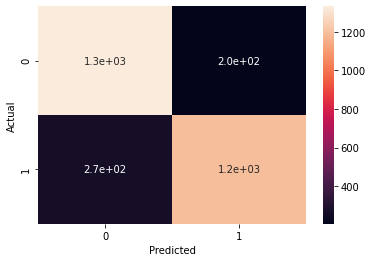

In [ ]:
### Naive Bayes
confusion_matrix_NB = pd.crosstab(Test_Y, predictions_NB, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix_NB,annot=True)
plt.show()

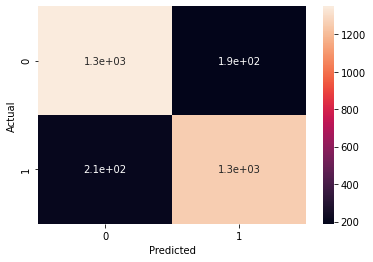

In [ ]:
### Support Vector Machine
confusion_matrix_SVM = pd.crosstab(Test_Y, predictions_SVM, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix_SVM,annot=True)
plt.show()

### Classification reports

In [ ]:
## Naive Bayes
print(classification_report(Test_Y,predictions_NB))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1537
           1       0.85      0.82      0.84      1463

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [ ]:
## Support Vector Machine
print(classification_report(Test_Y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1537
           1       0.87      0.86      0.86      1463

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



### Uploading dataset - 02

In [ ]:
# Musical Instruments Dataset
df02=pd.read_csv(r"C:\Users\admin\Downloads\Musical_instruments_reviews_dataset\Musical_instruments_reviews.csv",encoding='latin-1')

In [ ]:
df02

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"
...,...,...,...,...,...,...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","Great, just as expected. Thank to all.",5,Five Stars,1405814400,"07 20, 2014"
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014"
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4,Good for coated.,1405987200,"07 22, 2014"
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4,Taylor Made,1404172800,"07 1, 2014"


## Data Preprocessing

### Dropping unnecessary columns

In [ ]:
df02=df02.drop(columns =['reviewerID', 'asin','reviewerName','helpful','unixReviewTime','reviewTime','summary'])

In [ ]:
df02

,reviewText,overall
0,"Not much to write about here, but it does exac...",5
1,The product does exactly as it should and is q...,5
2,The primary job of this device is to block the...,5
3,Nice windscreen protects my MXL mic and preven...,5
4,This pop filter is great. It looks and perform...,5
...,...,...
10256,"Great, just as expected. Thank to all.",5
10257,I've been thinking about trying the Nanoweb st...,5
10258,I have tried coated strings in the past ( incl...,4
10259,"Well, MADE by Elixir and DEVELOPED with Taylor...",4


### Upper case to lower case transformation

In [ ]:
df02['reviewText']=df02['reviewText'].str.lower()

In [ ]:
df02

,reviewText,overall
0,"not much to write about here, but it does exac...",5
1,the product does exactly as it should and is q...,5
2,the primary job of this device is to block the...,5
3,nice windscreen protects my mxl mic and preven...,5
4,this pop filter is great. it looks and perform...,5
...,...,...
10256,"great, just as expected. thank to all.",5
10257,i've been thinking about trying the nanoweb st...,5
10258,i have tried coated strings in the past ( incl...,4
10259,"well, made by elixir and developed with taylor...",4


### Reconstructing the sentence

In [ ]:
df02['reviewText']=[reconstruct(sentence) for sentence in df02['reviewText']]
df02

,reviewText,overall
0,not much to write about here but it does exac...,5
1,the product does exactly as it should and is q...,5
2,the primary job of this device is to block the...,5
3,nice windscreen protects my mxl mic and preven...,5
4,this pop filter is great it looks and perform...,5
...,...,...
10256,great just as expected thank to all,5
10257,i ve been thinking about trying the nanoweb st...,5
10258,i have tried coated strings in the past incl...,4
10259,well made by elixir and developed with taylor...,4


### Word Tokenization

In [ ]:
df02['reviewText']= [word_tokenize(entry) for entry in df02['reviewText']]

In [ ]:
df02

,reviewText,overall
0,"[not, much, to, write, about, here, but, it, d...",5
1,"[the, product, does, exactly, as, it, should, ...",5
2,"[the, primary, job, of, this, device, is, to, ...",5
3,"[nice, windscreen, protects, my, mxl, mic, and...",5
4,"[this, pop, filter, is, great, it, looks, and,...",5
...,...,...
10256,"[great, just, as, expected, thank, to, all]",5
10257,"[i, ve, been, thinking, about, trying, the, na...",5
10258,"[i, have, tried, coated, strings, in, the, pas...",4
10259,"[well, made, by, elixir, and, developed, with,...",4


### Mapping ratings to positive->1 and negativ->0 classes

In [ ]:
#(4,5)->positive
#(1,2)->negative
#3->negative
removed_indices=list()
for index,rating in enumerate(df02['overall']):
    if rating in (4,5):
        sentiment=1
        df02.loc[index,'polarity'] = sentiment
    elif rating in (1,2):
        sentiment=0
        df02.loc[index,'polarity'] = sentiment
    else:
        df02 = df02.drop(index)
        removed_indices.append(index)
df02

,reviewText,overall,polarity
0,"[not, much, to, write, about, here, but, it, d...",5,1.0
1,"[the, product, does, exactly, as, it, should, ...",5,1.0
2,"[the, primary, job, of, this, device, is, to, ...",5,1.0
3,"[nice, windscreen, protects, my, mxl, mic, and...",5,1.0
4,"[this, pop, filter, is, great, it, looks, and,...",5,1.0
...,...,...,...
10256,"[great, just, as, expected, thank, to, all]",5,1.0
10257,"[i, ve, been, thinking, about, trying, the, na...",5,1.0
10258,"[i, have, tried, coated, strings, in, the, pas...",4,1.0
10259,"[well, made, by, elixir, and, developed, with,...",4,1.0


In [ ]:
df02 = df02.astype({"overall":'int',"polarity":'int'})

In [ ]:
# Rewriting the indices
i=0
for j in range(10261):
    if j not in removed_indices:
        df02.loc[j,'index1']=i
        i+=1
df02 = df02.astype({"index1":'int'})
df02.set_index("index1", inplace = True)

In [ ]:
df02

,reviewText,overall,polarity
index1,,,
0,"[not, much, to, write, about, here, but, it, d...",5,1
1,"[the, product, does, exactly, as, it, should, ...",5,1
2,"[the, primary, job, of, this, device, is, to, ...",5,1
3,"[nice, windscreen, protects, my, mxl, mic, and...",5,1
4,"[this, pop, filter, is, great, it, looks, and,...",5,1
...,...,...,...
9484,"[great, just, as, expected, thank, to, all]",5,1
9485,"[i, ve, been, thinking, about, trying, the, na...",5,1
9486,"[i, have, tried, coated, strings, in, the, pas...",4,1


### Removing Stopwords and Lemmatization

In [ ]:
## Defining set containing all stopwords in english
stpwordlist=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your',
 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's",
 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up',
 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where',
 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so',
 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y']

In [ ]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(df02['reviewText']):
    #if index not in removed_indices:
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stpwordlist and word.isalpha() and len(word)>2:
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df02.loc[index,'text_final'] = str(Final_words)

In [ ]:
df02

,reviewText,overall,polarity,text_final
index1,,,,
0,"[not, much, to, write, about, here, but, it, d...",5,1,"['not', 'much', 'write', 'exactly', 'suppose',..."
1,"[the, product, does, exactly, as, it, should, ...",5,1,"['product', 'exactly', 'should', 'quite', 'aff..."
2,"[the, primary, job, of, this, device, is, to, ...",5,1,"['primary', 'job', 'device', 'block', 'breath'..."
3,"[nice, windscreen, protects, my, mxl, mic, and...",5,1,"['nice', 'windscreen', 'protects', 'mxl', 'mic..."
4,"[this, pop, filter, is, great, it, looks, and,...",5,1,"['pop', 'filter', 'great', 'look', 'performs',..."
...,...,...,...,...
9484,"[great, just, as, expected, thank, to, all]",5,1,"['great', 'expect', 'thank']"
9485,"[i, ve, been, thinking, about, trying, the, na...",5,1,"['think', 'try', 'nanoweb', 'string', 'bit', '..."
9486,"[i, have, tried, coated, strings, in, the, pas...",4,1,"['try', 'coat', 'string', 'past', 'include', '..."


## Feature Extractor

### Splitting of dataset

In [ ]:
#preparing train and test datasets
Train_X,Test_X,Train_Y,Test_Y = model_selection.train_test_split(df02['text_final'],df02['polarity'],test_size=0.2)

In [ ]:
#Encoding
Encoder=LabelEncoder()
Train_Y=Encoder.fit_transform(Train_Y)
Test_Y=Encoder.fit_transform(Test_Y)

### TFIDF

In [ ]:
# It is a general process of turning a collection of text documents into numerical feature vectors.
#Their are many methods to convert text data to vectors which the model can understand but by far the most popular method is called TF-IDF.
#This is an acronym than stands for “Term Frequency — Inverse Document” Frequency which are the components of the resulting scores assigned to each word.
#Term Frequency: This summarizes how often a given word appears within a document.
#Inverse Document Frequency: This down scales words that appear a lot across documents.
#Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, 
#e.g. frequent in a document but not across documents.
#The following syntax can be used to first fit the TG-IDF model on the whole corpus. 
#This will help TF-IDF build a vocabulary of words which it has learned from the corpus data and it will assign a unique integer number to each of these words. 
#Their will be maximum of 5000 unique words/features as we have set parameter max_features=5000.
#Finally we will transform Train_X and Test_X to vectorized Train_X_Tfidf and Test_X_Tfidf. 
#These will now contain for each row a list of unique integer number and its associated importance as calculated by TF-IDF

Tfidf_vect=TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df02['text_final'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
##Output:
#1: Row number of ‘Train_X_Tfidf’, 
#2: Unique Integer number of each word in the first row, 
#3: Score calculated by TF-IDF Vectorizer
print(Train_X_Tfidf)

  (0, 4883)	0.08506356204839746
  (0, 4725)	0.07486087396160644
  (0, 4712)	0.09505721625815065
  (0, 4463)	0.04837349860253304
  (0, 4427)	0.054718440389646454
  (0, 4316)	0.11323639604318253
  (0, 4300)	0.06310019731067033
  (0, 4247)	0.06875148967973496
  (0, 4216)	0.10650993482415537
  (0, 4198)	0.08828451220036364
  (0, 4181)	0.057252528274970384
  (0, 4075)	0.03867263007522449
  (0, 3819)	0.056655002895285814
  (0, 3684)	0.07439841908001632
  (0, 3569)	0.11579367791284248
  (0, 3567)	0.09211853884590213
  (0, 3423)	0.23674488455542242
  (0, 3346)	0.08696534112849796
  (0, 3345)	0.10536537795559615
  (0, 3293)	0.09332244996237046
  (0, 3198)	0.11383971687955276
  (0, 3134)	0.11001544589121635
  (0, 3078)	0.09296946867585425
  (0, 2914)	0.10384009988023264
  (0, 2851)	0.11649972040616698
  :	:
  (7589, 2037)	0.2746183781139543
  (7589, 1950)	0.13029059427237877
  (7589, 1883)	0.1375406875283353
  (7589, 1598)	0.29417304708058833
  (7589, 1543)	0.2764372323251937
  (7589, 1102)	0.48

### Classifiers

In [ ]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",math.floor(accuracy_score(predictions_NB, Test_Y)*100))

Naive Bayes Accuracy Score ->  95


In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
#SVM = LinearSVC()
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",math.ceil(accuracy_score(predictions_SVM, Test_Y)*100))

SVM Accuracy Score ->  96
